# Trabajo Práctico de Redes Neuronales

Las librerías que utilizaremos serán las siguientes,

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import sklearn as skl
import pandas as pd
from copy import deepcopy
from sklearn.metrics import zero_one_loss, mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier

from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

Y las red neuronales por defecto serán definida por los siguientes parámetros y funciones,

In [51]:
# Parámetros estándar
epocas_por_entrenamiento = 25    # numero de epocas que entrena cada vez
eta  = 0.01                      # learning rate
alfa = 0.9                       # momentum
N2   = 60                        # neuronas en la capa oculta

def standardRegressionNetwork():
    return MLPRegressor(hidden_layer_sizes=(N2,), activation='logistic', solver='sgd', alpha=0.0, batch_size=1,
                        learning_rate='constant', learning_rate_init=eta,momentum=alfa,nesterovs_momentum=False,
                        tol=0.0,warm_start=True,max_iter=epocas_por_entrenamiento)

def standardClassifierNetwork():
    return MLPClassifier(hidden_layer_sizes=(N2,), activation='logistic', solver='sgd', alpha=0.0, batch_size=1,
                         learning_rate='constant', learning_rate_init=eta,momentum=alfa,nesterovs_momentum=False,
                         tol=0.0,warm_start=True,max_iter=epocas_por_entrenamiento)

Por último, una función de entrenamiento que utilizaremos en varios ejercicios es la siguiente,

In [2]:
@ignore_warnings(category=ConvergenceWarning)
def netTrain(net, evalsCount, X_train, y_train, X_val, y_val, X_test,  y_test):
    """
    Función que entrena una red ya definida previamente "evaluaciones" veces,
    cada vez entrenando un número de épocas elegido al crear la red y midiendo
    el error en train, validación y test al terminar ese paso de entrenamiento.
    Guarda y devuelve la red en el paso de evaluación que da el mínimo error de
    validación.

    Argumentos:
      red: red neuronal predefinida
      evaluaciones (int): las veces que evalua
      X_{}: los conjuntos de valores de entrada de train, validación y test
      y_{}: los conjuntos de valores de salida o clase

    Salidas:
      red: la red entrenada en el mínimo de validación
      error_{}: los errores de: train, validación y test medidos en cada
        evaluación
    """
    error_train = []
    error_val = []
    error_test = []
    best_val_error = 1.0
    best_net = net
    for eval in range(evalsCount):
      # red.partial_fit(X_train, y_train, classes=[0,1])
      ## Podríamos llamar partial_fit para realizar una sóla pasada a la vez,
      ## pero al ser muy costoso frenar y reanudar el entrenamiento realizamos
      ## varias épocas a la vez. Recordemos que la red fue definida con el
      ## parámetro 'sub-epocas', con lo cual cada llamado a 'fit' realiza esa
      ## cantidad de épocas
      net.fit(X_train, y_train)
      # error de training
      y_pred_train = net.predict(X_train)
      error_train.append(zero_one_loss(y_train, y_pred_train))
      # error de validacion
      y_pred_val = net.predict(X_val)
      cur_val_error = zero_one_loss(y_val, y_pred_val)
      error_val.append(cur_val_error)
      # error de test
      error_test.append(1 - net.score(X_test, y_test))
      if best_val_error > cur_val_error:
        best_val_error = cur_val_error
        best_net = deepcopy(net)
          
    return best_net, error_train, error_val, error_test


# Problema 1 - Capacidad de modelado

Entrene redes neuronales para resolver el problema de clasificación de las espirales anidadas que creamos en el TP 0. Use un número creciente de neuronas en la capa intermedia: 2, 10, 20, 40. Valores posibles para los demás parámetros de entrenamiento: learning rate 0.1, momentum 0.9, 600 datos para ajustar los modelos (20% de ese conjunto separarlo al azar para conjunto de validación), 2000 para testear, 1000 evaluaciones del entrenamiento, cada una de 20 épocas. Para cada uno de los cuatro modelos obtenidos, graficar en el plano xy las clasificaciones sobre el conjunto de test. Comentar.

## Resolución.
Comencemos por definir el generador de datos en espiral, 

In [4]:
def entre_curvas(rho, theta):
  rho_1 = theta/(4*math.pi)
  rho_2 = (theta + math.pi)/(4*math.pi)
  rho_3 = (theta + 2*math.pi)/(4*math.pi)
  rho_4 = (theta + 3*math.pi)/(4*math.pi)
  rho_5 = (theta + 4*math.pi)/(4*math.pi)
  rho_6 = (theta + 5*math.pi)/(4*math.pi)
  return (rho_1 < rho and rho < rho_2) or (rho_3 < rho and rho < rho_4) or (rho_5 < rho and rho < rho_6)

def espirales(n):

  inputs = []
  outputs = []

  cat0_t = 0
  cat1_t = 0
  while cat0_t + cat1_t != n:
    rho = math.sqrt(np.random.uniform())
    theta = np.random.uniform(-math.pi, math.pi)

    x = rho * math.cos(theta)
    y = rho * math.sin(theta)

    if entre_curvas(rho, theta) and cat0_t < n//2:
      inputs.append([x,y])
      outputs.append(0)
      cat0_t = cat0_t + 1
    elif (not entre_curvas(rho, theta)) and cat1_t < n//2:
      inputs.append([x,y])
      outputs.append(1)
      cat1_t = cat1_t + 1

  return pd.DataFrame({'input': inputs, 'output': outputs})

Ahora establecemos los parámetros de entrenamiento,

In [5]:
hiddenNeuronCount = [2, 10, 20, 40]

learningRate = 0.1
momentum = 0.9

trainSize = 600
validationProportion = 0.2

testSize = 2000

trainingEvals = 1000
epochsPerEval = 20

Y construímos los conjuntos de entrenamiento, validación, y de test,

In [7]:
# Separamos los 'trainSize' datos en los que realmente seran utilizados para entrenamiento y los que conformaran el conjunto de validacion.
trainSet, validationSet = skl.model_selection.train_test_split(espirales(trainSize), test_size = validationProportion)

# Y creamos el conjunto de test
testSet  = espirales(testSize)

Creamos las redes de clasificación con distinto número de neuronas en la capa oculta

In [92]:
classifiers = []

for neuronCount in hiddenNeuronCount:
    classifiers.append(MLPClassifier(hidden_layer_sizes=(neuronCount,), activation='logistic', solver='sgd', alpha=0.0, batch_size=1,
                        learning_rate='constant', learning_rate_init=learningRate,momentum=momentum,nesterovs_momentum=False,
                        tol=0.0,warm_start=True,max_iter=epochsPerEval))

Entrenamos cada modelo con los conjuntos obtenidos anteriormente

In [93]:
XTrain, YTrain = list(trainSet["input"]), list(trainSet["output"])
XValidation, YValidation = list(validationSet["input"]), list(validationSet["output"])
XTest, YTest = list(testSet["input"]), list(testSet["output"])

bestClassifiers = []

for classifier in classifiers:

    bestClassifier,_,_,_ = netTrain(classifier, trainingEvals, XTrain, YTrain, XValidation, YValidation, XTest, YTest)
    bestClassifiers.append(bestClassifier)

/home/martin/Downloads/machine_learning/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/martin/Downloads/machine_learning/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/martin/Downloads/machine_learning/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


KeyboardInterrupt: 

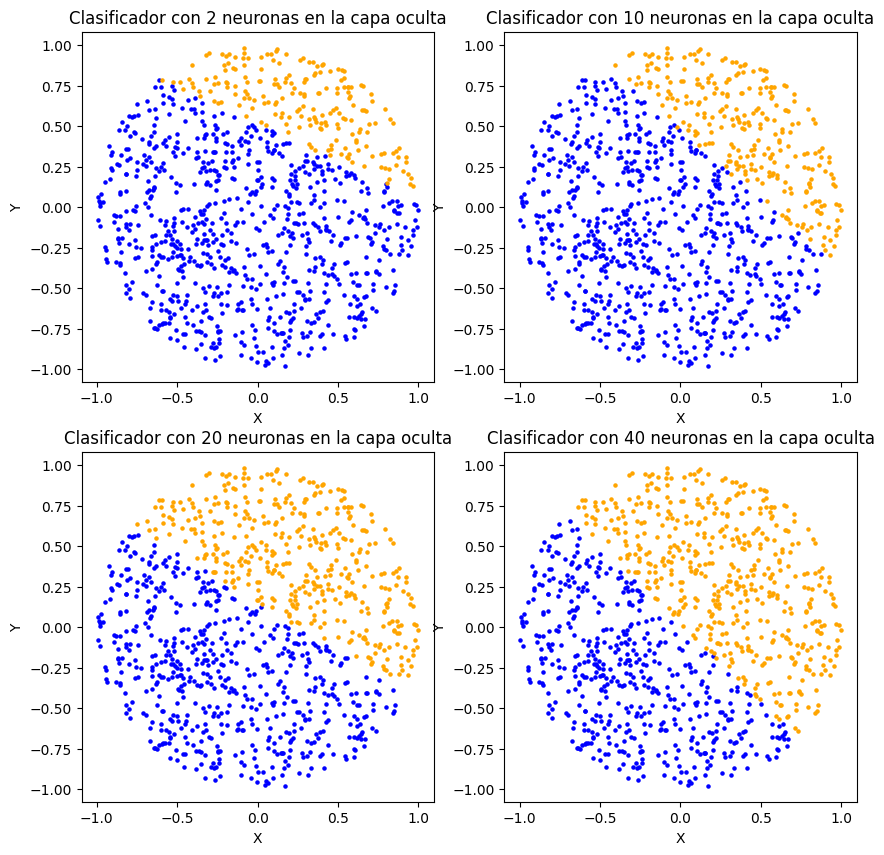

In [89]:
fig, axes = plt.subplots(2,2, figsize = (10,10))
axes = axes.flatten()

for i, classifier in enumerate(bestClassifiers):
    
    prediction = classifier.predict(XTest)

    testArray = np.array(XTest)
    
    class0 = testArray[prediction == 0] 
    class1 = testArray[prediction == 1] 

    axes[i].scatter(class0[:,0], class0[:,1], color="blue", s = 5)
    axes[i].scatter(class1[:,0], class1[:,1], color="orange", s = 5)

    axes[i].set(xlabel = 'X', ylabel = 'Y', title = f'Clasificador con {hiddenNeuronCount[i]} neuronas en la capa oculta')
    


# Problema 2 - Mínimos locales

Baje el dataset dos-elipses de la descargas. Realice varios entrenamientos con los siguientes parámetros: 6 neuronas en la capa intermedia, 500 patrones en el training set, de los cuales 400 se usan para entrenar y 100 para validar el modelo (sacados del .data), 2000 patrones en el test set (del .test), 300 evaluaciones del entrenamiento, cada una de 50 épocas. 

Pruebe distintos valores de momentum y learning-rate (valores usuales son 0, 0.5, 0.9 para el momentum y 0.1, 0.01, 0.001 para el learning-rate, pero no hay por qué limitarse a esos valores), para tratar de encontrar el mejor mínimo posible de la función error. El valor que vamos a usar es el promedio de 10 entrenamientos iguales, dado que los entrenamientos incorporan el azar. Como guía, con los parámetros dados, hay soluciones entre 5% y 6% de error en test, y tal vez mejores. Confeccione una tabla con los valores usados para los parámetros y el resultado en test obtenido (la media de las 10 ejecuciones). Haga una gráfica de error de train, validación y test en función del número de épocas para los valores seleccionados (los mejores valores de eta y alfa). 

# Problema 3 - Regularización

Baje el dataset Ikeda (en todos los problemas de regresión la última columna del dataset es la variable a precedir). Realice varios entrenamientos usando el 95% del archivo .data para entrenar, y el resto para validar. Realice otros entrenamientos cambiando la relación a 75%-25%, y a 50%-50%. En cada caso seleccione un resultado que considere adecuado, y genere gráficas del mse en train, validación y test. Comente sobre los resultados. 
Los otros parámetros para el entrenamiento son: learning rate 0.01, momentum 0.9, 2000 datos para testear, 400 evaluaciones del entrenamiento, cada una de 50 épocas, 30 neuronas en la capa oculta.

In [ ]:
@ignore_warnings(category=ConvergenceWarning)
def netTrain(net, evalsCount, X_train, y_train, X_val, y_val, X_test,  y_test):
    
    error_train = []
    error_val = []
    error_test = []
    best_val_error = 1.0
    best_net = net
    
    for eval in range(evalsCount):
        
        net.fit(X_train, y_train)
        
        # error de training
        y_pred_train = net.predict(X_train)
        error_train.append(mean_squared_error(y_train, y_pred_train))
        
        # error de validacion
        y_pred_val = net.predict(X_val)
        cur_val_error = mean_mean_squared_error(y_val, y_pred_val)
        error_val.append(cur_val_error)
    
        # error de test
        error_test.append(1 - net.score(X_test, y_test))
        
        if best_val_error > cur_val_error:
        best_val_error = cur_val_error
        best_net = deepcopy(net)
          
    return best_net, error_train, error_val, error_test


In [87]:
def divideDataFrame(df):

    X,Y = list(df["input"]), list(df["output"])
    return X,Y

In [10]:
validationProportions = [0.05, 0.25, 0.50]

learningRate = 0.01
momentum = 0.9

hiddenNeurons = 30

trainSize = 600

testSize = 2000 # Supongo que agarro el dataset de test y selecciono solamente 2000

trainingEvals = 400
epochsPerEval = 50

In [75]:
# Pierdo precision leyendo (?)

def dataFrameFromFile(path):

    df = pd.read_csv(path, sep='\s+', header=None)

    numCols = df.shape[1]

    X = df.iloc[:, :-1].values  
    y = df.iloc[:, -1].values  

    return pd.DataFrame({
        'input': list(X),
        'output': y
    })

In [86]:
# Cargo los datasets que voy a utilizar
ikedaData = dataFrameFromFile("ikeda.data")
ikedaTest = dataFrameFromFile("ikeda.test")

_, testSet = skl.model_selection.train_test_split(ikedaTest, test_size = testSize) # Nos quedamos con 'testSize' muestras del conjunto de test. Para todos es el mismo?

Primero preparo todos los conjuntos que necesite para realizar los entrenamientos con las distintas proporciones del conjunto de validación

In [93]:
trainAndValidation = []
regressors = []


for validationProportion in validationProportions:

    trainSet, validationSet = skl.model_selection.train_test_split(ikedaData, test_size = validationProportion)
    trainAndValidation.append((trainSet,validationSet))

    regressors.append(MLPRegressor(hidden_layer_sizes=(hiddenNeurons,), activation='logistic', solver='sgd', alpha=0.0, batch_size=1,
                        learning_rate='constant', learning_rate_init=learningRate,momentum=momentum,nesterovs_momentum=False,
                        tol=0.0,warm_start=True,max_iter=epochsPerEval))



# El conjunto de test siempre va a ser el mismo para todos los entrenamientos?

Ahora entreno en celdas separadas cada uno de los regresores para poder correrlos independientemente

In [90]:
trainSet, validationSet = trainAndValidation[0]
XTrain, YTrain = divideDataFrame(trainSet)
XValidation, YValidation = divideDataFrame(validationSet)
XTest, YTest = divideDataFrame(testSet)

regressor = regressors[0]

In [91]:
trainSet, validationSet = trainAndValidation[1]
XTrain, YTrain = divideDataFrame(trainSet)
XValidation, YValidation = divideDataFrame(validationSet)
XTest, YTest = divideDataFrame(testSet)

regressor = regressors[0]

In [92]:
trainSet, validationSet = trainAndValidation[2]
XTrain, YTrain = divideDataFrame(trainSet)
XValidation, YValidation = divideDataFrame(validationSet)
XTest, YTest = divideDataFrame(testSet)

regressor = regressors[0]

# Problema 4 - Regularización 
Vamos a usar regularización por penalización, el weight-decay. Hay que tener cuidado con los nombres de los parámetros en este caso. El parámetro que nosotros llamamos gamma en la teoría corresponde en MLP de sklearn al parámetro alpha, mientras que nosotros usamos alfa para el momentum en general. Para activarlo tenemos que usar,

In [ ]:
gamma=0.00001
regr = MLPRegressor(hidden_layer_sizes=(N2,), activation='logistic', solver='sgd', alpha=gamma, batch_size=1, learning_rate='constant', learning_rate_init=eta,momentum=alfa,nesterovs_momentum=False,tol=0.0,warm_start=True,max_iter=epocas_por_entrenamiento)

En este tipo de regularización no se usa un conjunto de validación, asi que hay que modificar la función que crearon para evaluar el entrenamiento de las redes, para que en lugar del error sobre el conjunto de validación, nos devuelva la suma de los valores absolutos o de los valores al cuadrado de todos los pesos de la red en la epoca correspondiente, y todo el resto igual que antes.

Una vez implementado, aplíquelo al dataset Sunspots (ssp). Busque el valor de gamma adecuado para conseguir un equilibrio entre evitar el sobreajuste y hacer el modelo demasiado rígido (el valor de gamma se debe variar en varios órdenes de magnitud, por ejemplo empezar en 10^-6 e ir hasta 10^0 (1) de a un orden cada vez). En este caso todos los registros del archivo .data se deben usar para el entrenamiento, ya que la regularización se realiza con la penalización a los pesos grandes. 
Los otros parámetros se pueden tomar: learning rate 0.05, momentum 0.3, 4000 evaluaciones del entrenamiento, cada una de 20 épocas, 6 neuronas en la capa intermedia.

Entregue curvas de los tres errores (entrenamiento y test en una figura, penalización en otra figura) para el valor de gamma elegido, y para algún otro valor en que haya observado sobreajuste. Comente los resultados.

# Problema 5 - Dimensionalidad
Repita el punto 4 del Práctico 1, usando ahora redes con 6 unidades en la capa intermedia. Los otros parámetros hay que setearlos adecuadamente, usando como guía los casos anteriores. Genere una gráfica que incluya los resultados de redes y árboles. 

**Resultados de error, predicción? Que cosa?**

# Problema 6 - Multiclase
Busque en los datasets de sklearn los archivos del problema iris y entrene una red sobre ellos. Tome un tercio de los datos como test, y los dos tercios restantes para entrenar y validar. Ajusto los parámetros de la red de manera conveniente. Realice curvas de entrenamiento, validación y test.

# Problema 7 - Minibatch
La implementaciín de sklearn permite usar minibaths cambiando el parámetro batch_size. Realice una comparación de las curvas de aprendizaje para el problema de Sunspots, utilizando batches de longitud 1 y otros dos valores (3 curvas). Comente los resultados. Parametros del entrenamiento: 20% de validación, learning rate 0.05, momentum 0.3, 2000 evaluaciones del entrenamiento, cada una de 200 épocas, 6 neuronas en la capa intermedia. Los valores del minibatch se deben elegir para que en cada etapa de entrenamiento haya varias actualizaciones del gradiente, o sea que no debería ser mayor a 40.

In [ ]:
validationProportion = 0.20
learningRate = 0.05

momentum = 0.3


hiddenNeurons = 6

trainSize = 600 # VER VALOR

testSize = 2000 # VER VALOR

trainingEvals = 2000
epochsPerEval = 200